In [24]:
import numpy as np
import pickle
import pathlib
import pyimfit
from astropy.io import fits
import corner
import matplotlib.pyplot as plt
import pandas as pd
from photutils import profiles

imageFile = "../fit/agn.fits"
imageAGN = fits.getdata(imageFile)

epsf = fits.getdata("../psfConstruction/psfResults/epsf.fits")
psf1 = fits.getdata("psf1.fits")

(array([3284., 5579.,  567.,  550.]),
 array([ -5.,   0.,   5.,  10., 100.]),
 <BarContainer object of 4 artists>)

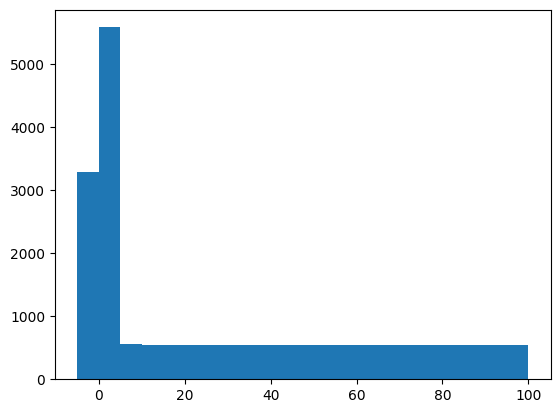

In [20]:
plt.hist(imageAGN.flatten(), bins=np.array([-5,0,5,10,100]))

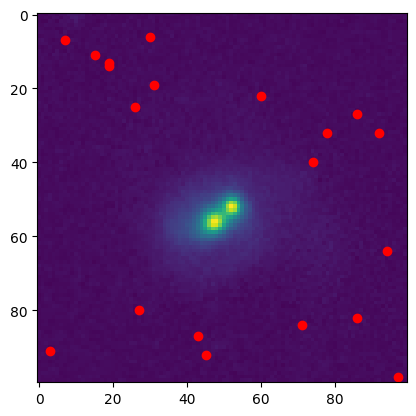

In [23]:
arr = imageAGN
flattened_arr = np.array(arr).flatten()
ys,xs = np.unravel_index(np.argsort(flattened_arr)[:20], arr.shape)
plt.imshow(imageAGN)
[plt.plot(xs[i],ys[i],"ro") for i in range(len(xs))];

In [25]:
def find_highest_indices(arr):
    flattened_arr = np.array(arr).flatten()
    max_indices = np.unravel_index(np.argsort(flattened_arr)[-2:], arr.shape)
    return max_indices


def galaxy_model(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, Xlim, Ylim,
                 PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                 PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim):
    """create galaxy model for ML fit
        including: ps: 1 psf + 1 sersic
                   psps: 2 psf + 2 sersic"""
    #=========models
    # Sersic
    sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 'fixed'],
    'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}
    sersic_dict = {'name': "Sersic", 'label': "bulge", 'parameters': sersic}
    # PSF
    psf = {'I_tot' : [Itot, Itot_lim[0], Itot_lim[1]]}
    psf_dict = {'name': "PointSource", 'label': "psf", 'parameters': psf}

    #========function dictionary
    # psf
    funcset_dict_psf0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    funcset_dict_psf1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    # sersic
    funcset_dict_sersic0 = {'X0': [Xss0,Xlim[0],Xlim[1]], 'Y0': [Yss0,Ylim[0],Ylim[1]], 
                   'function_list': [sersic_dict]}
    funcset_dict_sersic1 = {'X0': [Xss1,Xlim[0],Xlim[1]], 'Y0': [Yss1,Ylim[0],Ylim[1]], 
                   'function_list': [sersic_dict]}
    # overall sersic
    funcset_dict_sersicT = {'X0': [50,Xlim[0],Xlim[1]], 'Y0': [50,Ylim[0],Ylim[1]], 
                   'function_list': [sersic_dict]}
    # same center dictionaries
    funcset_dict_psfser0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict, sersic_dict]}
    funcset_dict_psfser1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict, sersic_dict]}
    
    #========model dict
    # same center models
    model_dict_ps_1c = {'function_sets': [funcset_dict_psfser0]}
    model_dict_psps_1c = {'function_sets': [funcset_dict_psfser0,funcset_dict_psfser1]}
    # different center
    model_dict_ps_2c = {'function_sets': [funcset_dict_psf0,funcset_dict_sersic0]}
    model_dict_psps_2c = {'function_sets': [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1]}
    # same center, overall sersic
    model_p1 = {'function_sets': [funcset_dict_psfser0, funcset_dict_sersicT]}
    model_p2 = {'function_sets': [funcset_dict_psfser0,funcset_dict_psfser1, funcset_dict_sersicT]}
    # diff center, overall sersic
    model_p3 = {'function_sets': [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1,funcset_dict_sersicT]}
    
    #========create model
    model_ps1c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_ps_1c)
    model_psps1c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_psps_1c)
    model_ps2c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_ps_2c)
    model_psps2c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_psps_2c)
    model_new1 = pyimfit.ModelDescription.dict_to_ModelDescription(model_p1)
    model_new2 = pyimfit.ModelDescription.dict_to_ModelDescription(model_p2)
    model_new3 = pyimfit.ModelDescription.dict_to_ModelDescription(model_p3)
    return model_ps1c, model_psps1c, model_ps2c, model_psps2c, model_new1, model_new2, model_new3



def doFit(models,epsf): 
    """do fit with data using PSF oversampled by factor of 4 over whole image
       return fitters"""
    fitters = []
    # oversamped PSF
    for i in tqdm.tqdm(range(len(models)), desc="Fitting Models"):
        imfit_fitter = pyimfit.Imfit(models[i],psf=epsf)
        imfit_fitter.loadData(imageAGN, psf_oversampling_list=osampleList, gain=9.942e-1, read_noise=0.22, original_sky=15.683)
        imfit_fitter.doFit()
        fitters.append(imfit_fitter)
    return fitters


def formatfit(bf):
    for i in bf:
        print(f"{i:.2f}, ", end="")
        
        
def plotNewP(fitter,newP,bf,pos2_ind):
    fig,ax = plt.subplots(1,3,figsize=(12,5))
    im0 = ax[0].imshow(imageAGN)
    [ax[i].plot(newP[0]-1,newP[1]-1,"ro",markersize=0.5,markerfacecolor='none') for i in range(3)]
    [ax[i].plot(newP[pos2_ind[0]]-1,newP[pos2_ind[1]]-1,"bo",markersize=0.5,markerfacecolor='none') for i in range(3)]
    m = fitter.getModelImage(newParameters=newP)
    im1 = ax[1].imshow(m)
    im2 =ax[2].imshow(imageAGN-m)
    [fig.colorbar([im0,im1,im2][i],ax=ax[i],shrink=0.7) for i in range(3)]
    [ax[i].set_title(["agn", "model", "residual"][i]) for i in range(3)];
    print("bf: ", fitter.computeFitStatistic(bf))
    print("new: ", fitter.computeFitStatistic(newP))
    
    
def plotRadial(m,dic):
    fig, ax = plt.subplots(1,3, figsize=(12,5))
    # create AGN profiles
    cenup = [dic["X0_1"]-1, dic['Y0_1']-1]
    cendown = [dic["X0_2"]-1, dic['Y0_2']-1]
    agn0p = profiles.RadialProfile(imageAGN,xycen=centeru,radii=np.arange(50))
    agn1p = profiles.RadialProfile(imageAGN,xycen=centerd,radii=np.arange(50))
    # create model profiles
    m0 = profiles.RadialProfile(m,xycen=cenup,radii=np.arange(50))
    m1 = profiles.RadialProfile(m,xycen=cendown,radii=np.arange(50))
    # plot model image and apertures
    im0 = ax[0].imshow(m)
    [agn0p.apertures[int(10*i)].plot(ax=ax[0],color='darkseagreen', lw=0.5) for i in range(5)]
    [agn1p.apertures[int(10*i)].plot(ax=ax[0],color='steelblue', lw=0.5) for i in range(5)]
    # plot agn & model radial profiles
    ax[1].plot(agn0p.radius, agn0p.profile, 'ko', label="AGN up true",markersize=2)
    ax[2].plot(agn1p.radius, agn1p.profile, 'ro', label="AGN down true",markersize=2)
    ax[1].plot(m0.radius, m0.profile, color='y', label="AGN up model")
    ax[2].plot(m1.radius, m1.profile, color='steelblue', label="AGN down model")
    [ax[i].legend() for i in [1,2]]
    [ax[i].set_title(["Every 10 apertures", "Radial profiles of 2 AGNs"][i]) for i in range(2)]
    ax[1].set_xlabel("Radius(pixels)")
    ax[1].set_ylabel("Intensity(counts)");
    

def dofit_no_oversp(modelNum, solver="NM"):
    fitter = pyimfit.Imfit(models_n1[modelNum],psf=psf1)
    fitter.loadData(imageAGN, gain=9.942e-1, read_noise=0.22, original_sky=654.63)
    fitter.doFit(solver)

    plt.imshow(fitter.getModelImage())
    plt.colorbar()

    p1 = fitter.getFitResult().params
    n1  = fitter.numberedParameterNames
    dic = dict(zip(n1,p1))

    print("Model #"+str(modelNum))
    print("\n")
    [print(f"{n1[i]}: {p1[i]:.3f}") for i in range(len(n1))]
    print("\n")
    print("ML:", fitter.getFitResult().fitStat)
    
    formatfit(fitter.getFitResult().params)
    
    plotRadial(fitter.getModelImage(),dic)
    
    return fitter.getModelImage(), p1, n1

## Looking at best-fit params (no bound on I_tot)

In [9]:
with open("../fit/fitResults/J1215+1344_fit.pkl", "rb") as file:
    d0 = pickle.load(file)  
    
modelName = ["1 psf+sersic same center", "2 psf+sersic same center","1 psf+sersic diff center", "2 psf+sersic diff center"]
dfs = [pd.DataFrame([d0['paramNames'][n],d0['bestfit_n1'][n]['params']],index=['',modelName[n]]).T for n in range(4)]
pd.concat(dfs, axis=1).fillna('')

,,1 psf+sersic same center,,2 psf+sersic same center,,1 psf+sersic diff center,,2 psf+sersic diff center
0,X0_1,49.3909,X0_1,53.417197,X0_1,36.363892,X0_1,0.000000
1,Y0_1,56.734992,Y0_1,53.410478,Y0_1,57.594167,Y0_1,87.551388
2,I_tot_1,1730.234184,I_tot_1,2121.113422,I_tot_1,192.421961,I_tot_1,-66.042703
3,PA_2,25.996351,PA_2,294.846291,X0_2,49.743543,X0_2,48.000001
4,ell_bulge_2,0.0,ell_bulge_2,0.406819,Y0_2,56.401981,Y0_2,52.000000
5,n_2,1.0,n_2,1.0,PA_2,62.663041,I_tot_2,6.154867
6,I_e_2,18.487047,I_e_2,1.417606,ell_bulge_2,0.389424,X0_3,63.846491
7,r_e_2,9.563689,r_e_2,27.520535,n_2,1.0,Y0_3,52.086142
8,,,X0_2,48.415827,I_e_2,33.640665,PA_3,200.000000
9,,,Y0_2,57.53788,r_e_2,9.16493,ell_bulge_3,0.100000


## Place limit on intensity, 0.1-1e4, ini guess 1500

In [3]:
ys,xs = find_highest_indices(imageAGN)
Imax = imageAGN.max()
itot=1500


#create galaxy models with n=1
models_n1 = galaxy_model(X0=xs[0], Y0=ys[0], 
                         X1=xs[1], Y1=ys[1], 
                         Xss0=xs[0], Yss0=ys[0], 
                         Xss1=xs[1], Yss1=ys[1],
                         Xlim=[0,100], Ylim=[0,100],
                         PA_ss=200, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                         PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0.1,Imax],
                         Iss_lim=[0.1,Imax], rss_lim=[0.1,100], Itot_lim=[0.1,1e4])



# Generate image to test position and intensity
I_tot is the integrated intensity. If want center to be 52,52 in model image, need to feed 53,53 to make model

ModelObjectWrapper: about to call _model.CreateModelImage()...
2800.0


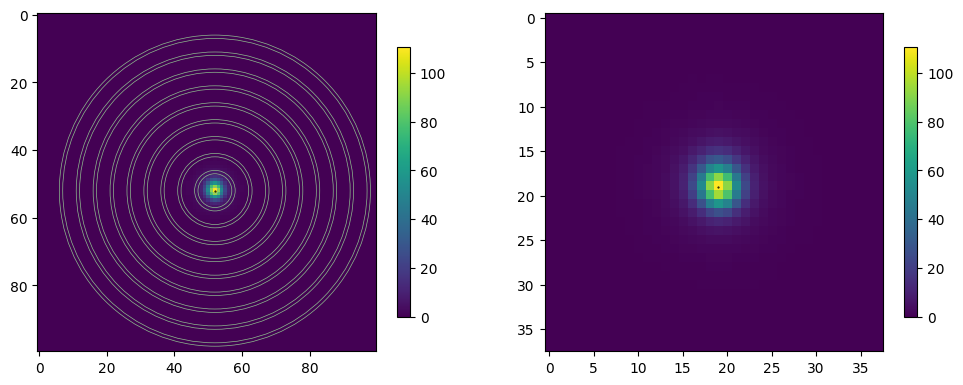

In [6]:
center0 = [52,52] #up
r0 = 19
x0 = np.round([center0[0]-r0, center0[0]+r0])
y0 = np.round([center0[1]-r0, center0[1]+r0])


s=1
Xlim=[0,100]
Ylim=[0,100]
X0=center0[0]+s
Y0=center0[1]+s
Itot=2800
Itot_lim=[0.1,1e4]


psf = {'I_tot' : [Itot, Itot_lim[0], Itot_lim[1]]}
psf_dict = {'name': "PointSource", 'label': "psf", 'parameters': psf}

funcset_dict_psf0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                'function_list': [psf_dict]}
model_dict  = {'function_sets': [funcset_dict_psf0]}
model_psfs = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict)


imfit_fitter = pyimfit.Imfit(model_psfs,psf=psf1)
modelIm = imfit_fitter.getModelImage(shape=(100,100))

fig,ax = plt.subplots(1,2,figsize=(12,5))
im0 = ax[0].imshow(modelIm)
ax[0].plot(center0[0],center0[1],"ko",markersize=.5)

im1 = ax[1].imshow(modelIm[y0[0]:y0[1],x0[0]:x0[1]])
[fig.colorbar([im0,im1][i],ax=ax[i],shrink=0.7) for i in range(2)]

rp = profiles.RadialProfile(modelIm,xycen=center0,radii=np.arange(50))
[rp.apertures[int(5*i)].plot(ax=ax[0],color='darkseagreen', lw=0.5) for i in range(10)]

ax[1].plot(19,19,"ko",markersize=.5)

print(np.sum(modelIm[y0[0]:y0[1],x0[0]:x0[1]]));

# True params intensity

Intensity AGN up:  2837.2725
Intensity AGN down:  1184.2399


''

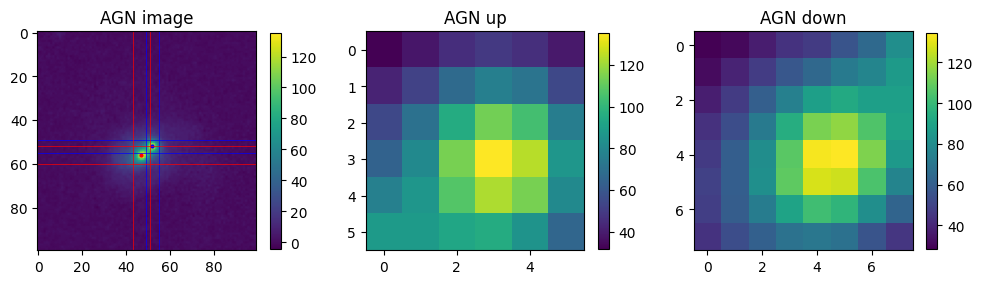

In [6]:
fig,ax = plt.subplots(1,3,figsize=(12,4))

centeru = [52,52] #up
centerd = [47,56] #down
r0 = 3
r1 = 4

xu = np.round([centeru[0]-r0, centeru[0]+r0])
yu = np.round([centeru[1]-r0, centeru[1]+r0])

xd = np.round([centerd[0]-r1, centerd[0]+r1])
yd = np.round([centerd[1]-r1, centerd[1]+r1])
           
im0 = ax[0].imshow(imageAGN)
ax[0].plot(centeru[0],centeru[1],"bo",markersize=2,label="up")
ax[0].plot(centerd[0],centerd[1],"ro",markersize=2,label = "down")

[ax[0].axvline(x = xu[i],color="b",lw=0.5) for i in range(2)]
[ax[0].axhline(y = yu[i],color="b",lw=0.5) for i in range(2)]

[ax[0].axvline(x = xd[i],color="r",lw=0.5) for i in range(2)]
[ax[0].axhline(y = yd[i],color="r",lw=0.5) for i in range(2)]

iu = np.sum(imageAGN[xu[0]:xu[1],yu[0]:yu[1]])
idw = np.sum(imageAGN[xd[0]:xd[1],yd[0]:yd[1]])
print("Intensity AGN up: ",iu)
print("Intensity AGN down: ",idw)

im1 = ax[1].imshow(imageAGN[yu[0]:yu[1],xu[0]:xu[1]])
im2 = ax[2].imshow(imageAGN[yd[0]:yd[1],xd[0]:xd[1]])

[fig.colorbar([im0,im1,im2][i],ax=ax[i],shrink=0.7) for i in range(3)]
[ax[i].set_title(["AGN image", "AGN up", "AGN down"][i]) for i in range(3)]
;


# True param radial profile

Radial profile integrated AGN up: 25448.698
Radial profile integrated AGN down: 25379.375
Intensity of whole image:25506.391


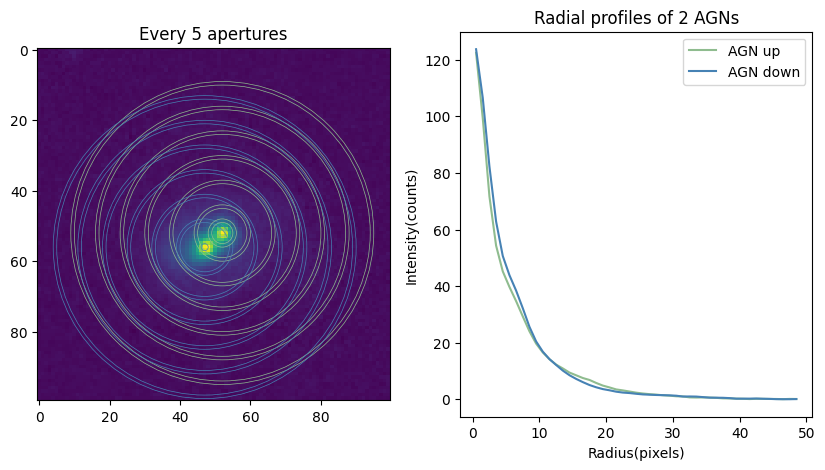

In [7]:
# plotting radial profiles
centeru = [52,52] #up
centerd = [47,56] #down
n = 7 # plot every n aperture

fig, ax = plt.subplots(1,2, figsize=(10,5))

agnup = profiles.RadialProfile(imageAGN,xycen=centeru,radii=np.arange(50))
agndp = profiles.RadialProfile(imageAGN,xycen=centerd,radii=np.arange(50))

im0 = ax[0].imshow(imageAGN)
[agnup.apertures[int(n*i)].plot(ax=ax[0],color='darkseagreen', lw=0.5) for i in range(len(agnup.radius)//n)]
[agndp.apertures[int(n*i)].plot(ax=ax[0],color='steelblue', lw=0.5) for i in range(len(agnup.radius)//n)]
#psf1.normalize("max")

agnup.apertures[int(3)].plot(ax=ax[0],color='darkseagreen', lw=0.5)

ax[1].plot(agnup.radius, agnup.profile, color='darkseagreen', label="AGN up")
ax[1].plot(agndp.radius, agndp.profile, color='steelblue', label="AGN down")
ax[1].legend()

[ax[i].set_title(["Every 5 apertures", "Radial profiles of 2 AGNs"][i]) for i in range(2)]
ax[1].set_xlabel("Radius(pixels)")
ax[1].set_ylabel("Intensity(counts)");

print(f"Radial profile integrated AGN up: {np.sum(agnup.profile*agnup.area):.3f}")
print(f"Radial profile integrated AGN down: {np.sum(agndp.profile*agndp.area):.3f}")
print(f"Intensity of whole image:{np.sum(imageAGN):.3f}")

In [30]:
hdue = fits.open('../psfConstruction/2020-02-21_J_J1215+1344_c1-4_58900_32019.mos.fits')
hdur = hdue[0].header
hdur

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 4513 / Axis length                                    
NAXIS2  =                 4495 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2020-10-23T22:16:16' / Date FITS file was generated                  
IRAF-TLM= '2020-10-23T22:16:13' / Time of last modification                     
OBJECT  = 'J1215+1344'         / Name of the object observed                    
EQUINOX =        2000.00000000 / Mean equinox                                   
MJD-OBS =   5.890100000000E+04 / Modified Julian date at start                  
RADESYS = 'ICRS    '        

In [31]:
hdu = fits.open('../fit/agn.fits')
hdu[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                  100 / Axis length                                    
NAXIS2  =                  100 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2020-10-23T22:16:16' / Date FITS file was generated                  
IRAF-TLM= '2020-10-23T22:16:13' / Time of last modification                     
OBJECT  = 'J1215+1344'         / Name of the object observed                    
EQUINOX =        2000.00000000 / Mean equinox                                   
MJD-OBS =   5.890100000000E+04 / [d] MJD of observation                         
RADESYS = 'ICRS    '        

# oversampled psf, 2psfs, same center model

PsfOversampling: starting initialization...
141
PsfOversampling: done.
PsfOversampling: starting __dealloc__.
PsfOversampling: done with __dealloc__.
bf:  35.435384873138396
53.42, 53.56, 2112.90, 246.35, 0.82, 1.00, 5.07, 19.09, 48.54, 57.65, 1999.64, 0.00, 0.00, 1.00, 11.63, 10.63, 

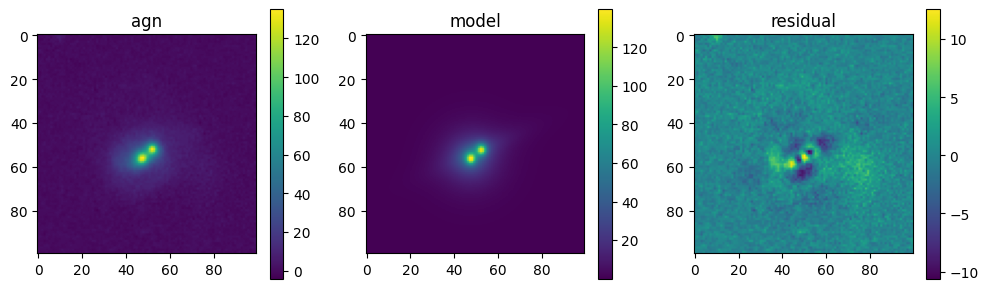

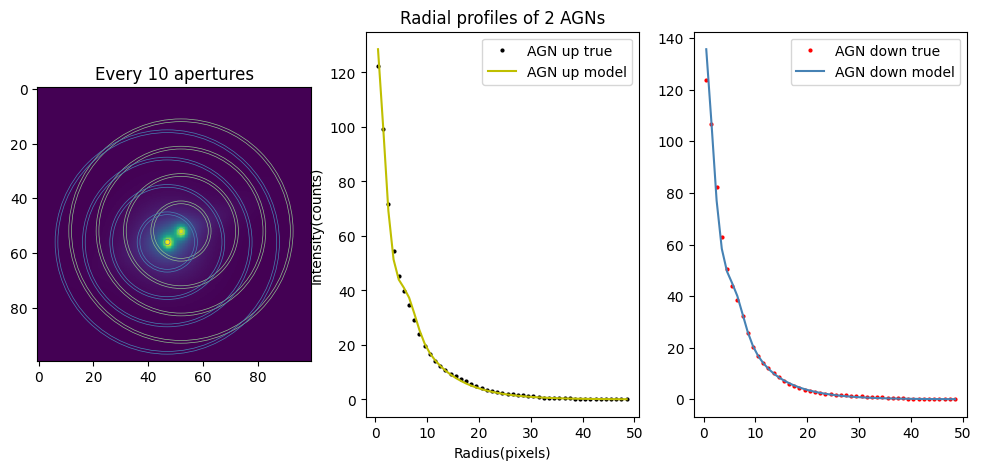

In [29]:
psfOsamp = pyimfit.MakePsfOversampler(epsf, 4, (1,100,1,100))
osampleList = [psfOsamp]
fitter = pyimfit.Imfit(d0['fitConfig_n1'][1],psf=epsf)
#fitter.loadData(imageAGN, psf_oversampling_list=osampleList, gain=9.942e-1, read_noise=0.22, original_sky=15.683)
fitter.loadData(imageAGN, psf_oversampling_list=osampleList, gain=9.942e-1, read_noise=0.22, original_sky=654.63)
fitter.doFit()

fig,ax = plt.subplots(1,3,figsize=(12,5))
im0 = ax[0].imshow(imageAGN)
m = fitter.getModelImage()
im1 = ax[1].imshow(m)
im2 =ax[2].imshow(imageAGN-m)
[fig.colorbar([im0,im1,im2][i],ax=ax[i],shrink=0.7) for i in range(3)]
[ax[i].set_title(["agn", "model", "residual"][i]) for i in range(3)];
print("bf: ", fitter.getFitResult().fitStat)
formatfit(fitter.getFitResult().params)
plotRadial(m,dict(zip(fitter.numberedParameterNames,fitter.getFitResult().params)))

# Not oversampled psf

Model #0


X0_1: 49.431
Y0_1: 56.335
I_tot_1: 1226.481
PA_2: 335.557
ell_bulge_2: 0.000
n_2: 1.000
I_e_2: 27.004
r_e_2: 8.079


ML: 151.82953645615598
49.43, 56.34, 1226.48, 335.56, 0.00, 1.00, 27.00, 8.08, 

KeyError: 'X0_2'

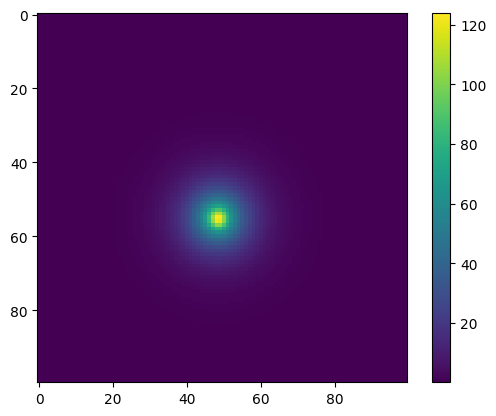

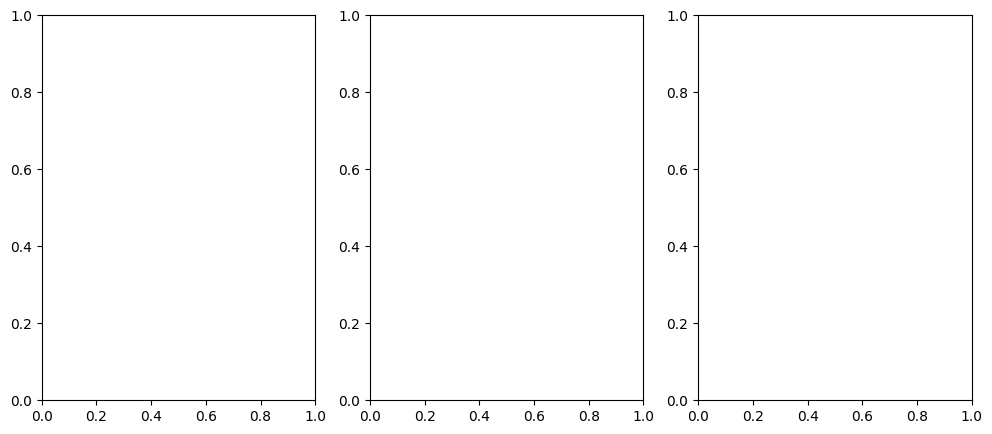

In [16]:
im0, p0, n0 = dofit_no_oversp(0)

Model #1


X0_1: 48.371
Y0_1: 57.208
I_tot_1: 2426.917
PA_2: 253.148
ell_bulge_2: 0.353
n_2: 1.000
I_e_2: 14.680
r_e_2: 12.908
X0_2: 53.223
Y0_2: 53.111
I_tot_3: 2435.423
PA_4: 359.997
ell_bulge_4: 0.492
n_4: 1.000
I_e_4: 13.430
r_e_4: 2.155


ML: 30.532123276390834
48.37, 57.21, 2426.92, 253.15, 0.35, 1.00, 14.68, 12.91, 53.22, 53.11, 2435.42, 360.00, 0.49, 1.00, 13.43, 2.15, 

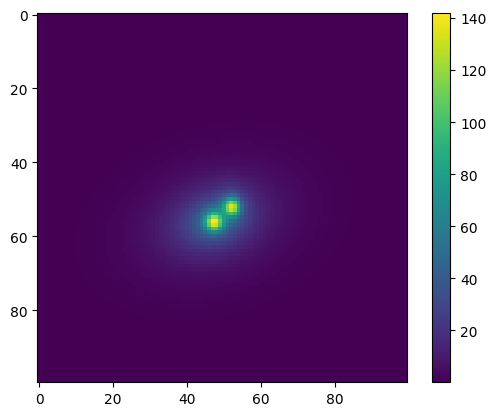

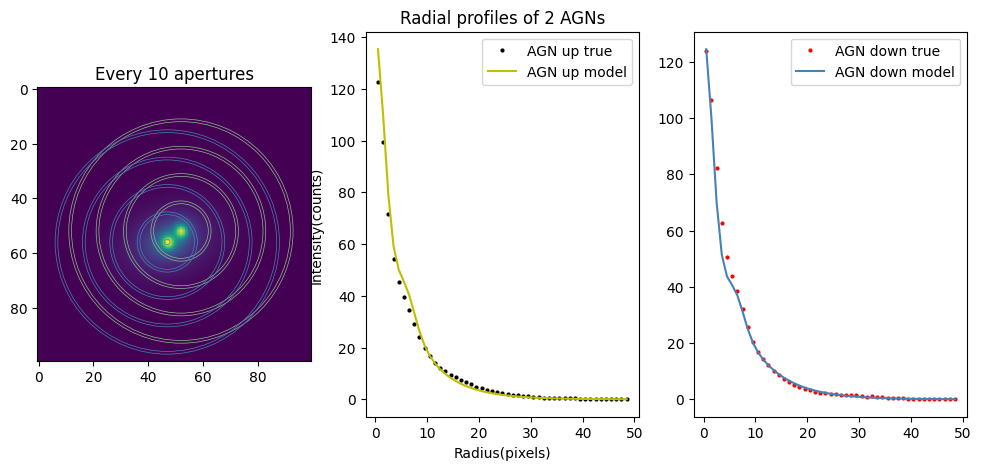

In [27]:
im1, p1, n1 = dofit_no_oversp(1)

Model #3


X0_1: 53.309
Y0_1: 53.398
I_tot_1: 1829.853
X0_2: 48.657
Y0_2: 57.521
I_tot_2: 2178.309
X0_3: 13.727
Y0_3: 61.535
PA_3: 218.896
ell_bulge_3: 0.132
n_3: 1.000
I_e_3: 0.968
r_e_3: 23.956
X0_4: 53.285
Y0_4: 39.546
PA_4: 0.000
ell_bulge_4: 0.155
n_4: 1.000
I_e_4: 1.220
r_e_4: 22.441


ML: 419.44098332323733
53.31, 53.40, 1829.85, 48.66, 57.52, 2178.31, 13.73, 61.53, 218.90, 0.13, 1.00, 0.97, 23.96, 53.28, 39.55, 0.00, 0.15, 1.00, 1.22, 22.44, 

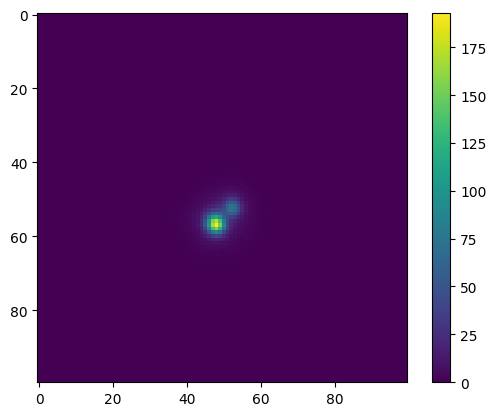

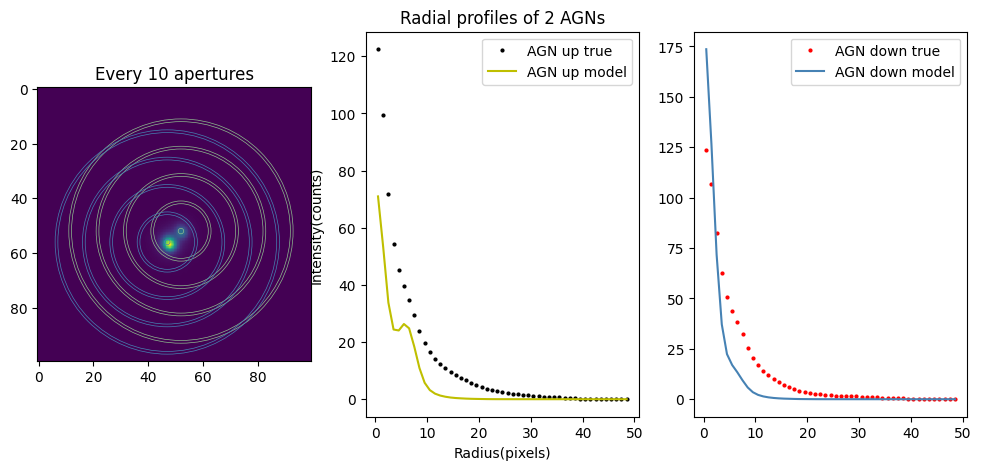

In [30]:
im3, p3, n3 = dofit_no_oversp(3)

Model #5


X0_1: 48.234
Y0_1: 57.364
I_tot_1: 3444.902
PA_2: 231.034
ell_bulge_2: 0.116
n_2: 1.000
I_e_2: 7.810
r_e_2: 14.923
X0_2: 53.278
Y0_2: 53.443
I_tot_3: 1956.933
PA_4: 83.798
ell_bulge_4: 0.774
n_4: 1.000
I_e_4: 0.291
r_e_4: 46.032
X0_3: 76.750
Y0_3: 77.005
PA_5: 337.223
ell_bulge_5: 0.446
n_5: 1.000
I_e_5: 1.440
r_e_5: 2.274


ML: 49.9442609722547
48.23, 57.36, 3444.90, 231.03, 0.12, 1.00, 7.81, 14.92, 53.28, 53.44, 1956.93, 83.80, 0.77, 1.00, 0.29, 46.03, 76.75, 77.01, 337.22, 0.45, 1.00, 1.44, 2.27, 

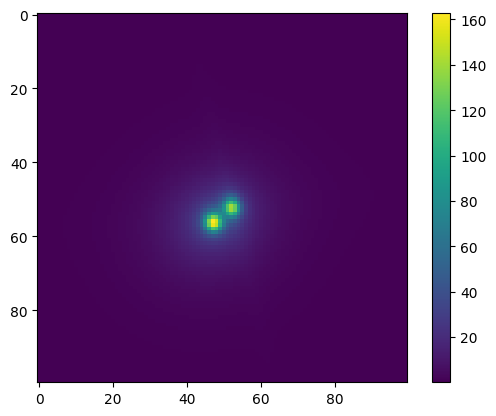

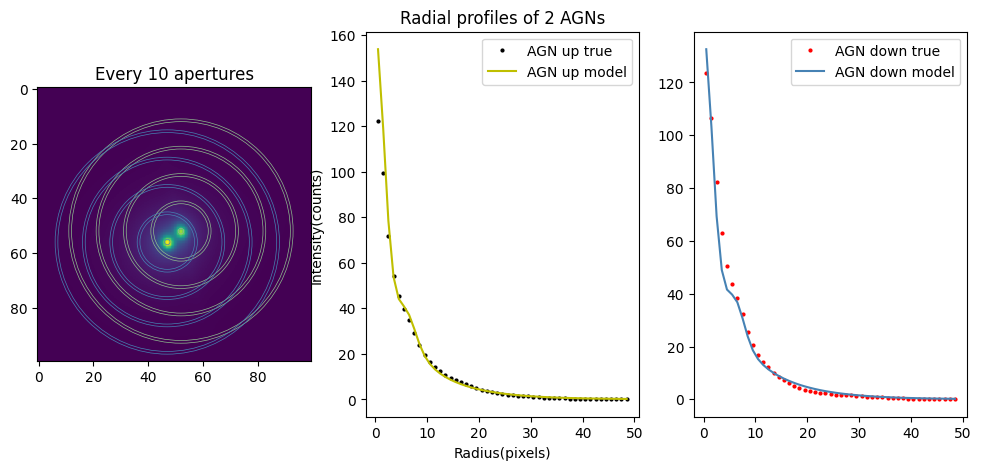

In [31]:
im5, p5, n5 = dofit_no_oversp(5)


*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimizati

Model #6


X0_1: 48.000
Y0_1: 56.000
I_tot_1: 1500.000
X0_2: 52.000
Y0_2: 52.000
I_tot_2: 1500.000
X0_3: 48.000
Y0_3: 56.000
PA_3: 200.000
ell_bulge_3: 0.100
n_3: 1.000
I_e_3: 1.000
r_e_3: 20.000
X0_4: 52.000
Y0_4: 52.000
PA_4: 200.000
ell_bulge_4: 0.100
n_4: 1.000
I_e_4: 1.000
r_e_4: 20.000
X0_5: 50.000
Y0_5: 50.000
PA_5: 200.000
ell_bulge_5: 0.100
n_5: 1.000
I_e_5: 1.000
r_e_5: 20.000


ML: nan
48.00, 56.00, 1500.00, 52.00, 52.00, 1500.00, 48.00, 56.00, 200.00, 0.10, 1.00, 1.00, 20.00, 52.00, 52.00, 200.00, 0.10, 1.00, 1.00, 20.00, 50.00, 50.00, 200.00, 0.10, 1.00, 1.00, 20.00, 

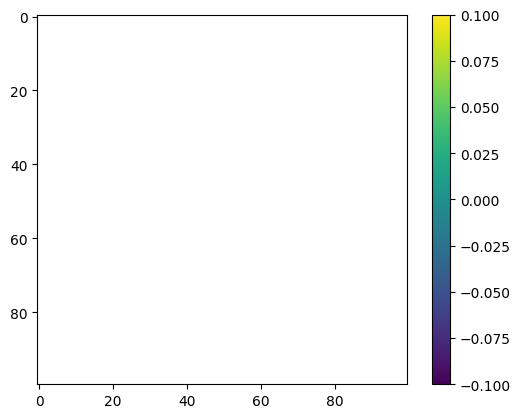

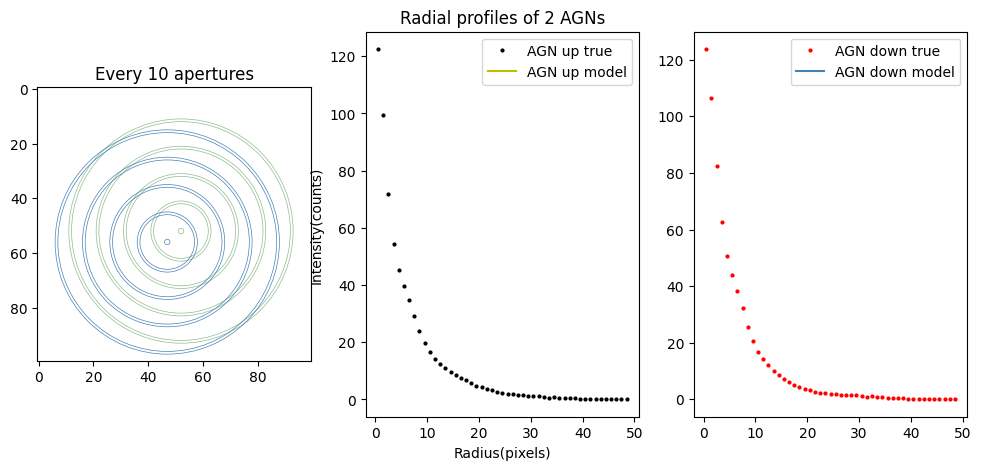

In [105]:
im6, p6, n6 = dofit_no_oversp(6)